In [1]:
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

In [6]:
plotdir = r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\pictures and plots\LFP rasters"

# Load experiment

In [7]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100


In [8]:
choose_sub = 7
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
print(exp.mouse)

Experiment type: electrical stimulation
771427


In [9]:
plotsavedir = os.path.join(plotdir, 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

THstim_d2


Get coords for stim electrode

In [10]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [11]:
stim_elec_data

{'surface': {'area': 'RSPd1', 'ccf_coords': [270, 12, 204]},
 'tip': {'area': 'CL', 'ccf_coords': [263, 131, 198]}}

## Load other data

### Load stim log and simple log

In [12]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [13]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [14]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0


### Iso times

In [31]:
iso_level, isots = exp.load_analog_iso()
iso_induction, iso_maintenance = exp.load_iso_times()

### Load pupil diameter, if it exists

In [16]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilD)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        sm_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilD[:k]
    sm_pupil[-k-1:] = pupilD[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilD)) / len(pupilD)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [17]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])

### Load running

In [18]:
# running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

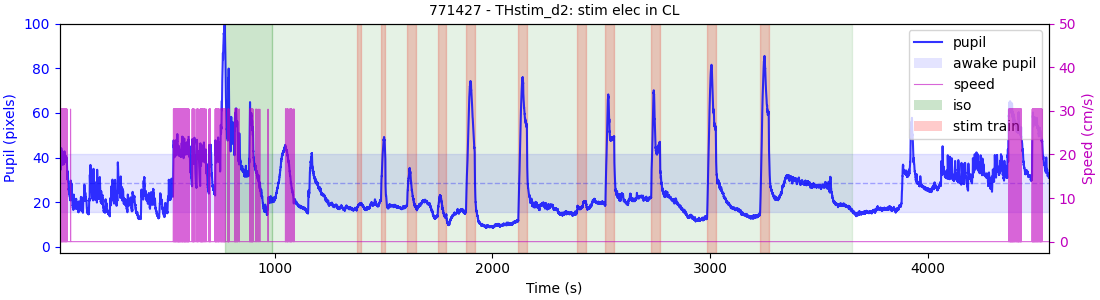

In [21]:
fig, ax = plt.subplots(figsize=(11,3), constrained_layout=True)
## Pupil ##
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc='b', alpha=0.1, label='awake pupil')
pup, = ax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
ax.set_xlim([pupilts[0], pupilts[-1]])
ax.set_ylim([-2.5, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil (pixels)', color='b')
ax.tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    ax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
## Running ##
runax = ax.twinx()
run, = runax.plot(speedts, speed, color='m', linewidth=0.8, alpha=0.6, label='speed')
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-2, 50])
## Iso level ##
ax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
ax.axvspan(iso_maintenance[0], iso_maintenance[1], color='g', alpha=0.1)
isp = mpatches.Rectangle((0, 0), 1, 1, fc='g', alpha=0.2, label='iso')
## Set title and legend ##
ax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
ax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

## Load neural data

### Load unit data

In [23]:
fn_units_info = os.path.join(exp.data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,D1,probeD,12,3520,0.164824,MRN,341,159,197,5.457882,0.83,0.033551,0.122209,24564,MB
1,D3,probeD,18,3460,0.494472,MRN,342,156,195,3.335076,0.80,0.037437,0.000143,15010,MB
2,D5,probeD,50,3140,0.384590,MRN,344,145,187,4.518239,0.94,0.771015,0.500000,20335,MB
3,D6,probeD,60,3040,0.343384,MRN,344,141,185,4.096966,0.98,4.572036,0.500000,18439,MB
4,D8,probeD,54,3100,0.315913,MRN,344,143,186,0.041550,0.33,0.000000,0.332388,187,MB


In [24]:
print(np.unique(unit_info['parent_region'].values))

['ACA' 'HIP' 'HPF' 'MB' 'MO' 'RHP' 'SS' 'STR' 'TH' 'VIS']


In [25]:
THunitdf = unit_info[unit_info['parent_region'] == 'TH']
print(np.unique(THunitdf['region'].values))

['LP' 'PF' 'PO']


In [26]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

ACA: 6 units
HIP: 57 units
HPF: 11 units
MB: 63 units
MO: 75 units
RHP: 46 units
SS: 27 units
STR: 63 units
TH: 253 units
VIS: 103 units


### Load LFP

In [27]:
collect_LFP = {
    'probeD': {'VIS': 305},
    'probeE': {'SS': 290},
    'probeF': {'ACA': 155, 'MO': 215},
}
deltat = 10. # window size, s
ctx_LFPs = {}
ctx_spectra = {}
for probei, chinfo in collect_LFP.items():
    print(probei)
    ## Load LFP as memmap ##
    lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
    lfp_data_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r').reshape(
        (len(lfp_ts), exp.ephys_params[probei]['num_chs']))
    for regi, chi in chinfo.items():
        print(' {}: Loading data...'.format(regi))
        ## Get chosen ch converted ##
        lfp_ch = lfp_data_mm[:, chi] * exp.ephys_params[probei]['bit_volts']
        ## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
        hardware_filter = signal.butter(1, Wn=[0.5, 500], btype='band', fs=exp.ephys_params[probei]['lfp_sample_rate'])
        lfp_ch = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_ch)))
        ## Store the LFP ##
        ctx_LFPs[regi] = [lfp_ts, lfp_ch]
    
        lfp_fs = exp.ephys_params[probei]['lfp_sample_rate']
        
        ### Get the spectra for rest/run/iso ###
        print('  Getting spectra...')
        ctx_spectra[regi] = {}
        ## Get deltat-sized bins and associated speeds ##
        awakebins = np.arange(lfp_ts[0], iso_induction[0], deltat)
        firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
        isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)
        tempsp = []
        for x in awakebins:
            tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
        awakespeeds = np.array(tempsp)[:-1]
        tempsp = []
        for x in isobins:
            tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
        isospeeds = np.array(tempsp)[:-1]
        ## Get awake spectra ##
        awake_Pxx = []
        for timei in awakebins[:-1]:
            tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
            frex, Pxx = signal.welch(
                lfp_ch[tinds], exp.ephys_params[probei]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probei]['lfp_sample_rate'],
            )
            awake_Pxx.append(Pxx)
        awake_Pxx = np.array(awake_Pxx)
        ctx_spectra[regi]['rest'] = [frex, np.mean(awake_Pxx[awakespeeds == 0, :], axis=0)]
        ctx_spectra[regi]['run'] = [frex, np.mean(awake_Pxx[awakespeeds > 1, :], axis=0)]
        ## Get anesthetized spectra ##
        iso_Pxx = []
        for timei in isobins[:-1]:
            tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
            frex, Pxx = signal.welch(
                lfp_ch[tinds], exp.ephys_params[probei]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probei]['lfp_sample_rate'],
            )
            iso_Pxx.append(Pxx)
        iso_Pxx = np.array(iso_Pxx)
        ctx_spectra[regi]['iso'] = [frex, np.mean(iso_Pxx[isospeeds == 0, :], axis=0)]
        print('  ...done.\n')

probeD
 VIS: Loading data...
  Getting spectra...
  ...done.

probeE
 SS: Loading data...
  Getting spectra...
  ...done.

probeF
 ACA: Loading data...
  Getting spectra...
  ...done.

 MO: Loading data...
  Getting spectra...
  ...done.



## Plot an event

In [52]:
choose_event = 5
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

stim_type      freq50Hz
parameter           100
duration             40
onset        2118.02391
offset       2158.02416
sweep                 0
Name: 5, dtype: object


,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
8000,freq50Hz,5,biphasic,100,2118.02391,2118.02431,0.0004,0
8001,freq50Hz,5,biphasic,100,2118.04391,2118.04431,0.0004,0
8002,freq50Hz,5,biphasic,100,2118.06391,2118.06431,0.0004,0
8003,freq50Hz,5,biphasic,100,2118.08391,2118.08431,0.0004,0
8004,freq50Hz,5,biphasic,100,2118.10391,2118.10431,0.0004,0


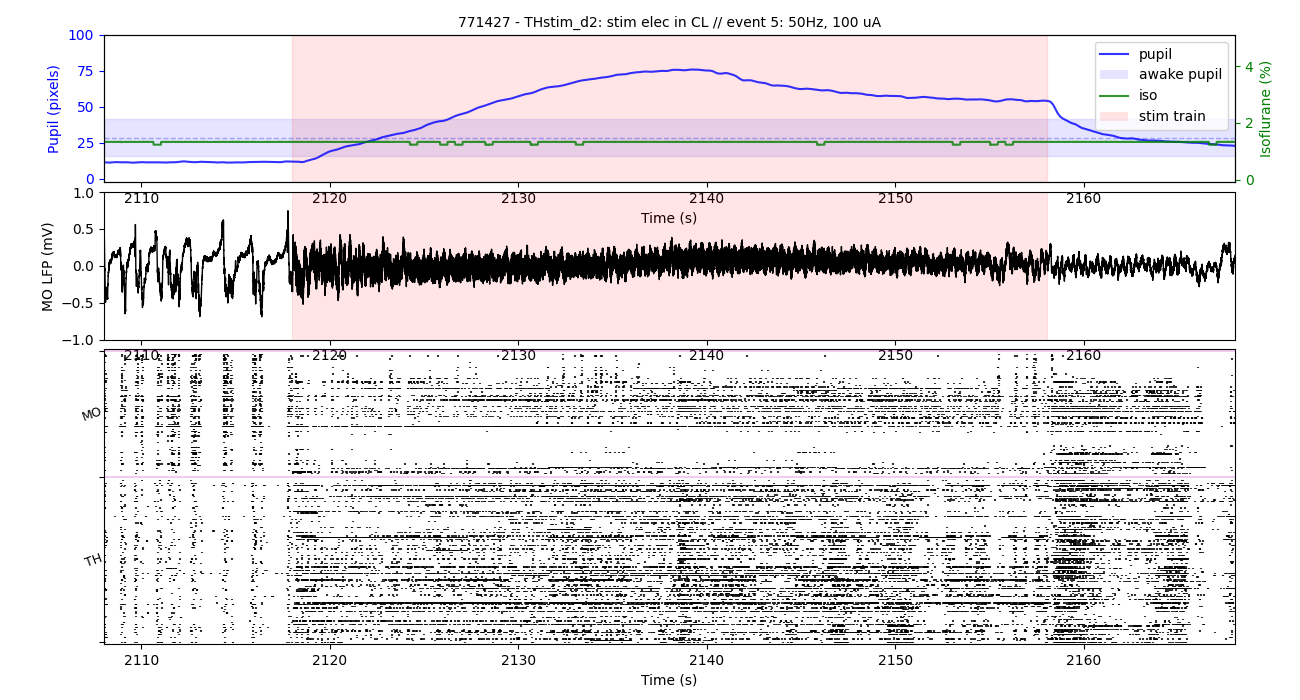

In [53]:
plot_region = 'MO'
umax = 100
pdelta = 10. # plot before and after, s
pwindow = [eventrow.onset - pdelta, eventrow.offset + pdelta]

fig = plt.figure(figsize=(13, 7)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=3, left=0.08, right=0.95, top=0.95, bottom=0.08, hspace=0.05, height_ratios=[1,1,2])
ax = fig.add_subplot(gs[0])
lfpax = fig.add_subplot(gs[1], sharex=ax)
rasterax = fig.add_subplot(gs[2], sharex=ax)

### Plot behavior ###
## Pupil ##
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc='b', alpha=0.1, label='awake pupil')
pup, = ax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
ax.set_ylim([-2.5, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil (pixels)', color='b')
ax.tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    ax.axvspan(traini.onset, traini.offset, color='r', alpha=0.1)
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.1, label='stim train')
# for si, stimi in event_stims.iterrows():
#     ax.axvline(stimi.onset, color='r', linewidth=0.8, alpha=0.1)
    # lfpax.axvline(stimi.onset, color='r', linewidth=0.8, alpha=0.1)
## Iso level ##
isoax = ax.twinx()
isp, = isoax.plot(isots, iso_level, color='g', alpha=0.8, label='iso')
isoax.set_ylabel('Isoflurane (%)', color='g')
isoax.tick_params(axis='y', colors='g')
isoax.set_ylim([-0.1, 5.1])
## Set title and legend ##
ax.set_title('{} - {}: stim elec in {} // event {:d}: {}, {:d} uA'.format(
    exp.mouse, exp_tag, stim_elec_data['tip']['area'], choose_event, eventrow.stim_type[4:], eventrow.parameter))
ax.legend(handles = [pup, pupat, isp, spat], loc='upper right')

ax.set_xlim(pwindow)

### Plot the filtered LFP ###
lfpax.plot(ctx_LFPs[plot_region][0], ctx_LFPs[plot_region][1] * 1E-3, color='k', linewidth=1.0)
lfpax.set_ylabel('{} LFP (mV)'.format(plot_region))
lfpax.set_ylim([-1, 1])
lfpax.axvspan(eventrow.onset, eventrow.offset, color='r', linewidth=0.8, alpha=0.1)

### Plot raster ###
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(['TH', plot_region]):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=0.8, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(pwindow[0], last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwindow)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = '{}{}_event{:d}_{}LFPraster.png'.format(exp.mouse, exp_tag, choose_event, plot_region)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)